# Maximize Locations

In this notebook, we will enhance our processed roadside attraction dataset by incorporating additional locations to help populate our selected region, California. This includes adding cities, national parks, amusement parks, and other notable destinations to enrich our representation of the state.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
import json
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import os

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'processed_roadside_attractions.csv')

df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (11696, 8)
Columns: ['index', 'title', 'year', 'image', 'image_link', 'state', 'category', 'decade']

First few rows:
   index                                              title    year  \
0      1        Teapot Dome gas station, Zillah, Washington  1987.0   
1      2  Harold's Auto Center, horizontal view, Sinclai...  1979.0   
2      4  Bomber gas station, diagonal view, Route 99 E....  1980.0   
3      5  Hat n' Boots gas station, overall view, Route ...  1980.0   
4      6  Hat n' Boots gas station (1945), boot restroom...  1977.0   

        image                                         image_link state  \
0  00001v.jpg  https://cdn.loc.gov/service/pnp/mrg/00000/0000...    WA   
1  00002v.jpg  https://cdn.loc.gov/service/pnp/mrg/00000/0000...    FL   
2  00004v.jpg  https://cdn.loc.gov/service/pnp/mrg/00000/0000...    OR   
3  00005v.jpg  https://cdn.loc.gov/service/pnp/mrg/00000/0000...    WA   
4  00006v.jpg  https://cdn.loc.gov/service/pnp/mrg/00000/0000...    WA

In [3]:
ca_df = df[df['state'] == 'CA'].copy()

print(f"California DataFrame shape: {ca_df.shape}")
print(f"California has {len(ca_df)} attractions")

print("\nFirst few California attractions:")
print(ca_df[['title', 'category', 'year']].head(10))

print("\nCalifornia attraction categories:")
print(ca_df['category'].value_counts())

print(f"\nCalifornia data summary:")
print(f"Year range: {ca_df['year'].min()} - {ca_df['year'].max()}")
print(f"Decades represented: {sorted(ca_df['decade'].unique())}")

California DataFrame shape: (944, 8)
California has 944 attractions

First few California attractions:
                                                title      category    year
5   World's Largest Redwood Tree Service Station (...   Gas Station  1991.0
20  Gordon Spencer gas station, 4691 Huntington Dr...   Gas Station  1977.0
35  Mattoon Service Station (pre-fabricated), angl...   Gas Station  1977.0
36     Richfield Gas, Route 66, Cucamonga, California   Gas Station  1978.0
50  Golden Eagle gas pumps, 8th & Market Streets, ...   Gas Station  1977.0
51  Far-Go gas pumps, Main Street, Barstow, Califo...   Gas Station  1979.0
61  Earl Schieb Auto Painting sign, upper detail, ...  Auto Service  1991.0
66  Compton Car Wash, Rosecrans Avenue, Compton, C...  Auto Service  1981.0
67  Delta Queen Car Wash, side view, Hamilton Aven...  Auto Service  1977.0
68  Delta Queen Car Wash, front view, Hamilton Ave...  Auto Service  1991.0

California attraction categories:
category
Other            

Great! there are a total of 944 attractions in California. Although most of the attractions are from the 1970's to the 2000's, and are heavily skewed towards the "other" category. Lets look further into this to create some more diversity. 

In [4]:
ca_cities = []
for title in ca_df['title']:
    if ',' in title:
        parts = title.split(',')
        if len(parts) >= 2:
            city = parts[-2].strip()
            if city and len(city) < 50:
                ca_cities.append(city)

city_counts = Counter(ca_cities)
print(f"Top 15 California cities represented:")
for city, count in city_counts.most_common(15):
    print(f"  {city}: {count} attractions")

major_ca_cities = [
    'Los Angeles', 'San Francisco', 'San Diego', 'Sacramento', 
    'Fresno', 'Oakland', 'Bakersfield', 'Anaheim', 'Santa Ana',
    'Riverside', 'Stockton', 'Irvine', 'Fremont', 'San Jose',
    'Modesto', 'Oxnard', 'Fontana', 'Moreno Valley', 'Huntington Beach',
    'Glendale', 'Santa Clarita', 'Garden Grove', 'Oceanside', 'Rancho Cucamonga',
    'Santa Rosa', 'Ontario', 'Lancaster', 'Elk Grove', 'Corona', 'Palmdale',
    'Yosemite', 'Palm Springs', 'Napa', 'Sonoma', 'Monterey', 'Big Sur',
    'Lake Tahoe', 'Mammoth Lakes', 'Death Valley', 'Joshua Tree'
]

missing_cities = [city for city in major_ca_cities if city not in ca_cities]
print(f"\nMajor California cities missing from dataset: {len(missing_cities)}")
print("Missing cities:")
for city in missing_cities:
    print(f"  • {city}")

print(f"\nCurrent categories in California data:")
print(ca_df['category'].value_counts())

missing_categories = [
    'National Park', 'State Park', 'Amusement Park', 'Museum', 
    'Beach', 'Landmark', 'Wine Region', 'Scenic Drive', 'Aquarium',
    'Observatory', 'Ski Resort', 'Mountain', 'Lake', 'Historical Site'
]

print(f"\nImportant categories missing from California data:")
for category in missing_categories:
    print(f"  • {category}")

Top 15 California cities represented:
  Los Angeles: 72 attractions
  San Diego: 67 attractions
  Bakersfield: 49 attractions
  Fresno: 39 attractions
  San Luis Obispo: 31 attractions
  Rialto: 28 attractions
  Riverside: 25 attractions
  Eureka: 24 attractions
  Santa Monica: 22 attractions
  Sacramento: 19 attractions
  Sherman Oaks: 18 attractions
  Fountain Valley: 17 attractions
  Oakland: 17 attractions
  San Bernardino: 16 attractions
  Stockton: 16 attractions

Major California cities missing from dataset: 25
Missing cities:
  • San Francisco
  • Anaheim
  • Irvine
  • Fremont
  • San Jose
  • Moreno Valley
  • Huntington Beach
  • Glendale
  • Santa Clarita
  • Garden Grove
  • Oceanside
  • Rancho Cucamonga
  • Ontario
  • Lancaster
  • Elk Grove
  • Palmdale
  • Yosemite
  • Palm Springs
  • Napa
  • Sonoma
  • Monterey
  • Big Sur
  • Lake Tahoe
  • Mammoth Lakes
  • Death Valley

Current categories in California data:
category
Other               549
Lodging             1

Okay good, we have some useful information on big cities like LA and San Diego, but it looks like we are missing information on other big cities such as San Francisco and Anaheim. Also there aren't any national parks here. Let's start adding some.

__I used AI here to type everything for the additional_ca_locations. I got this data from explorethedata.com__

In [5]:
additional_ca_locations = [
    # National Parks
    {"title": "Yosemite National Park", "category": "National Park", "city": "Yosemite Valley", "lat": 37.8651, "lon": -119.5383},
    {"title": "Redwood National and State Parks", "category": "National Park", "city": "Crescent City", "lat": 41.2132, "lon": -124.0046},
    {"title": "Death Valley National Park", "category": "National Park", "city": "Death Valley", "lat": 36.5323, "lon": -116.9325},
    {"title": "Joshua Tree National Park", "category": "National Park", "city": "Twentynine Palms", "lat": 33.8734, "lon": -115.9010},
    {"title": "Sequoia National Park", "category": "National Park", "city": "Three Rivers", "lat": 36.4864, "lon": -118.5658},
    {"title": "Kings Canyon National Park", "category": "National Park", "city": "Three Rivers", "lat": 36.7369, "lon": -118.5841},
    {"title": "Lassen Volcanic National Park", "category": "National Park", "city": "Mineral", "lat": 40.4977, "lon": -121.4207},
    {"title": "Channel Islands National Park", "category": "National Park", "city": "Ventura", "lat": 34.0522, "lon": -119.2433},
    {"title": "Pinnacles National Park", "category": "National Park", "city": "Paicines", "lat": 36.4905, "lon": -121.1833},
    
    # Major Cities/landmarks
    {"title": "Golden Gate Bridge", "category": "Landmark", "city": "San Francisco", "lat": 37.8199, "lon": -122.4783},
    {"title": "Hollywood Sign", "category": "Landmark", "city": "Los Angeles", "lat": 34.1341, "lon": -118.3215},
    {"title": "Alcatraz Island", "category": "Landmark", "city": "San Francisco", "lat": 37.8270, "lon": -122.4230},
    {"title": "Fisherman's Wharf", "category": "Tourist Attraction", "city": "San Francisco", "lat": 37.8080, "lon": -122.4177},
    {"title": "Disneyland", "category": "Amusement Park", "city": "Anaheim", "lat": 33.8121, "lon": -117.9190},
    {"title": "Universal Studios Hollywood", "category": "Amusement Park", "city": "Los Angeles", "lat": 34.1381, "lon": -118.3534},
    {"title": "Six Flags Magic Mountain", "category": "Amusement Park", "city": "Valencia", "lat": 34.4254, "lon": -118.5962},
    {"title": "Knott's Berry Farm", "category": "Amusement Park", "city": "Buena Park", "lat": 33.8443, "lon": -118.0001},
    {"title": "Legoland California", "category": "Amusement Park", "city": "Carlsbad", "lat": 33.1286, "lon": -117.3119},
    
    # Beaches
    {"title": "Venice Beach", "category": "Beach", "city": "Los Angeles", "lat": 33.9850, "lon": -118.4695},
    {"title": "Santa Monica Pier", "category": "Tourist Attraction", "city": "Santa Monica", "lat": 34.0083, "lon": -118.4977},
    {"title": "Malibu Beach", "category": "Beach", "city": "Malibu", "lat": 34.0259, "lon": -118.7798},
    {"title": "La Jolla Cove", "category": "Beach", "city": "San Diego", "lat": 32.8328, "lon": -117.2713},
    {"title": "Coronado Beach", "category": "Beach", "city": "Coronado", "lat": 32.6859, "lon": -117.1831},
    {"title": "Pismo Beach", "category": "Beach", "city": "Pismo Beach", "lat": 35.1428, "lon": -120.6413},
    {"title": "Big Sur", "category": "Scenic Drive", "city": "Big Sur", "lat": 36.2704, "lon": -121.8081},
    
    # Wine Country
    {"title": "Napa Valley Wine Region", "category": "Wine Region", "city": "Napa", "lat": 38.2975, "lon": -122.2869},
    {"title": "Sonoma Valley Wine Region", "category": "Wine Region", "city": "Sonoma", "lat": 38.2919, "lon": -122.4580},
    {"title": "Paso Robles Wine Region", "category": "Wine Region", "city": "Paso Robles", "lat": 35.6266, "lon": -120.6910},
    
    # Historical Sites
    {"title": "Mission San Juan Capistrano", "category": "Historical Site", "city": "San Juan Capistrano", "lat": 33.5017, "lon": -117.6626},
    {"title": "Mission San Francisco de Asís", "category": "Historical Site", "city": "San Francisco", "lat": 37.7648, "lon": -122.4269},
    {"title": "Mission Santa Barbara", "category": "Historical Site", "city": "Santa Barbara", "lat": 34.4383, "lon": -119.7148},
    {"title": "Sutter's Fort", "category": "Historical Site", "city": "Sacramento", "lat": 38.5816, "lon": -121.4944},
    {"title": "Bodie Ghost Town", "category": "Historical Site", "city": "Bodie", "lat": 38.2121, "lon": -119.0131},
    
    # Museums and Cultural Sites
    {"title": "Getty Center", "category": "Museum", "city": "Los Angeles", "lat": 34.0776, "lon": -118.4750},
    {"title": "LACMA", "category": "Museum", "city": "Los Angeles", "lat": 34.0562, "lon": -118.3594},
    {"title": "California Science Center", "category": "Museum", "city": "Los Angeles", "lat": 34.0169, "lon": -118.2887},
    {"title": "Exploratorium", "category": "Museum", "city": "San Francisco", "lat": 37.8024, "lon": -122.3976},
    {"title": "California Academy of Sciences", "category": "Museum", "city": "San Francisco", "lat": 37.7694, "lon": -122.4662},
    {"title": "Monterey Bay Aquarium", "category": "Aquarium", "city": "Monterey", "lat": 36.6183, "lon": -121.9016},
    
    # Scenic Drives and Natural Wonders
    {"title": "Pacific Coast Highway", "category": "Scenic Drive", "city": "Various", "lat": 36.2704, "lon": -121.8081},
    {"title": "Lake Tahoe", "category": "Lake", "city": "South Lake Tahoe", "lat": 38.9399, "lon": -119.9772},
    {"title": "Mammoth Mountain", "category": "Ski Resort", "city": "Mammoth Lakes", "lat": 37.6485, "lon": -119.0373},
    {"title": "Mount Shasta", "category": "Mountain", "city": "Mount Shasta", "lat": 41.4097, "lon": -122.1948},
    {"title": "Mono Lake", "category": "Lake", "city": "Lee Vining", "lat": 37.9975, "lon": -119.0187},
    {"title": "Anza-Borrego Desert State Park", "category": "State Park", "city": "Borrego Springs", "lat": 33.2550, "lon": -116.3981},
    
    # Unique Roadside Attractions
    {"title": "Cabazon Dinosaurs", "category": "Roadside Attraction", "city": "Cabazon", "lat": 33.9172, "lon": -116.7872},
    {"title": "Salvation Mountain", "category": "Roadside Attraction", "city": "Niland", "lat": 33.2547, "lon": -115.4725},
    {"title": "Integratron", "category": "Roadside Attraction", "city": "Landers", "lat": 34.3658, "lon": -116.3897},
    {"title": "Bottle Tree Ranch", "category": "Roadside Attraction", "city": "Oro Grande", "lat": 34.5989, "lon": -117.3342},
    {"title": "World's Largest Thermometer", "category": "Roadside Attraction", "city": "Baker", "lat": 35.2655, "lon": -116.0745},
    {"title": "Palm Springs Aerial Tramway", "category": "Tourist Attraction", "city": "Palm Springs", "lat": 33.8303, "lon": -116.5453},
    {"title": "Balboa Park", "category": "Park", "city": "San Diego", "lat": 32.7323, "lon": -117.1491},
    {"title": "Griffith Observatory", "category": "Observatory", "city": "Los Angeles", "lat": 34.1184, "lon": -118.3004},
    
    # Major Cities
    {"title": "San Jose Downtown", "category": "City Center", "city": "San Jose", "lat": 37.3382, "lon": -121.8863},
    {"title": "Fremont Central Park", "category": "Park", "city": "Fremont", "lat": 37.5485, "lon": -121.9886},
    {"title": "Irvine Spectrum Center", "category": "Shopping Center", "city": "Irvine", "lat": 33.6846, "lon": -117.8265},
    {"title": "Huntington Beach Pier", "category": "Landmark", "city": "Huntington Beach", "lat": 33.6559, "lon": -118.0050},
    {"title": "Glendale Galleria", "category": "Shopping Center", "city": "Glendale", "lat": 34.1425, "lon": -118.2551},
    {"title": "Santa Clarita Valley", "category": "Scenic Drive", "city": "Santa Clarita", "lat": 34.3917, "lon": -118.5426},
    {"title": "Garden Grove Historical Society", "category": "Historical Site", "city": "Garden Grove", "lat": 33.7739, "lon": -117.9414},
    {"title": "Oceanside Pier", "category": "Landmark", "city": "Oceanside", "lat": 33.1959, "lon": -117.3795},
    {"title": "Rancho Cucamonga Epicenter", "category": "Entertainment", "city": "Rancho Cucamonga", "lat": 34.1064, "lon": -117.5931},
    {"title": "Ontario Mills", "category": "Shopping Center", "city": "Ontario", "lat": 34.0633, "lon": -117.6509},
    {"title": "Lancaster Museum of Art and History", "category": "Museum", "city": "Lancaster", "lat": 34.6868, "lon": -118.1542},
    {"title": "Elk Grove Regional Park", "category": "Park", "city": "Elk Grove", "lat": 38.4088, "lon": -121.3716},
    {"title": "Palmdale Aerospace Walk of Honor", "category": "Landmark", "city": "Palmdale", "lat": 34.5794, "lon": -118.1165}
]

print(f"Created {len(additional_ca_locations)} additional California locations with coordinates")
print("Categories represented:")
categories = [loc['category'] for loc in additional_ca_locations]
category_counts = Counter(categories)
for category, count in category_counts.most_common():
    print(f"  {category}: {count}")

print(f"\nCities represented:")
cities = [loc['city'] for loc in additional_ca_locations]
city_counts = Counter(cities)
for city, count in city_counts.most_common(10):
    print(f"  {city}: {count}")

# Show some sample locations with coordinates
print(f"\nSample locations with coordinates:")
for i, loc in enumerate(additional_ca_locations[:5]):
    print(f"  {i+1}. {loc['title']} ({loc['city']}) - Lat: {loc['lat']}, Lon: {loc['lon']}")

Created 66 additional California locations with coordinates
Categories represented:
  National Park: 9
  Landmark: 6
  Historical Site: 6
  Museum: 6
  Amusement Park: 5
  Beach: 5
  Roadside Attraction: 5
  Tourist Attraction: 3
  Scenic Drive: 3
  Wine Region: 3
  Park: 3
  Shopping Center: 3
  Lake: 2
  Aquarium: 1
  Ski Resort: 1
  Mountain: 1
  State Park: 1
  Observatory: 1
  City Center: 1
  Entertainment: 1

Cities represented:
  Los Angeles: 7
  San Francisco: 6
  Three Rivers: 2
  San Diego: 2
  Yosemite Valley: 1
  Crescent City: 1
  Death Valley: 1
  Twentynine Palms: 1
  Mineral: 1
  Ventura: 1

Sample locations with coordinates:
  1. Yosemite National Park (Yosemite Valley) - Lat: 37.8651, Lon: -119.5383
  2. Redwood National and State Parks (Crescent City) - Lat: 41.2132, Lon: -124.0046
  3. Death Valley National Park (Death Valley) - Lat: 36.5323, Lon: -116.9325
  4. Joshua Tree National Park (Twentynine Palms) - Lat: 33.8734, Lon: -115.901
  5. Sequoia National Park (T

## Creation of enhanced_attractions.csv

In [7]:
# Convert additional locations to DataFrame format matching your original dataset
enhanced_locations = []

for i, location in enumerate(additional_ca_locations):
    enhanced_location = {
        'index': len(df) + i + 1,  # Continue the index sequence
        'title': location['title'],
        'year': 2024,  # Current year for new additions
        'image': '',  # No image for new additions
        'image_link': '',
        'state': 'CA',
        'category': location['category'],
        'decade': 2020,  # 2020s decade
        'latitude': location['lat'],
        'longitude': location['lon'],
        'city': location['city']
    }
    enhanced_locations.append(enhanced_location)

# Convert to DataFrame
enhanced_df = pd.DataFrame(enhanced_locations)

print(f"Enhanced DataFrame shape: {enhanced_df.shape}")
print(f"Sample of enhanced locations:")
print(enhanced_df[['title', 'category', 'city', 'latitude', 'longitude']].head())

# Combine with original dataset
combined_df = pd.concat([df, enhanced_df], ignore_index=True)

print(f"\nCombined dataset summary:")
print(f"Original dataset: {len(df)} locations")
print(f"Enhanced dataset: {len(enhanced_df)} new locations")
print(f"Combined dataset: {len(combined_df)} total locations")

# Show California summary after enhancement
ca_enhanced = combined_df[combined_df['state'] == 'CA']
print(f"\nCalifornia locations after enhancement: {len(ca_enhanced)}")
print("California categories after enhancement:")
print(ca_enhanced['category'].value_counts())

# Show new categories added
original_categories = set(df['category'].unique())
enhanced_categories = set(combined_df['category'].unique())
new_categories = enhanced_categories - original_categories
print(f"\nNew categories added: {len(new_categories)}")
for category in sorted(new_categories):
    print(f"  • {category}")

# Save the enhanced dataset
combined_df.to_csv('enhanced_attractions.csv', index=False)
print(f"\nEnhanced dataset saved as 'enhanced_roadside_attractions.csv'")

Enhanced DataFrame shape: (66, 11)
Sample of enhanced locations:
                              title       category              city  \
0            Yosemite National Park  National Park   Yosemite Valley   
1  Redwood National and State Parks  National Park     Crescent City   
2        Death Valley National Park  National Park      Death Valley   
3         Joshua Tree National Park  National Park  Twentynine Palms   
4             Sequoia National Park  National Park      Three Rivers   

   latitude  longitude  
0   37.8651  -119.5383  
1   41.2132  -124.0046  
2   36.5323  -116.9325  
3   33.8734  -115.9010  
4   36.4864  -118.5658  

Combined dataset summary:
Original dataset: 11696 locations
Enhanced dataset: 66 new locations
Combined dataset: 11762 total locations

California locations after enhancement: 1010
California categories after enhancement:
category
Other                  549
Lodging                110
Gas Station             90
Restaurant              87
Sign/Billboa

Great! The dataset is now much larger and provides many more genres to see! Lets take a look at the bigger picture now.

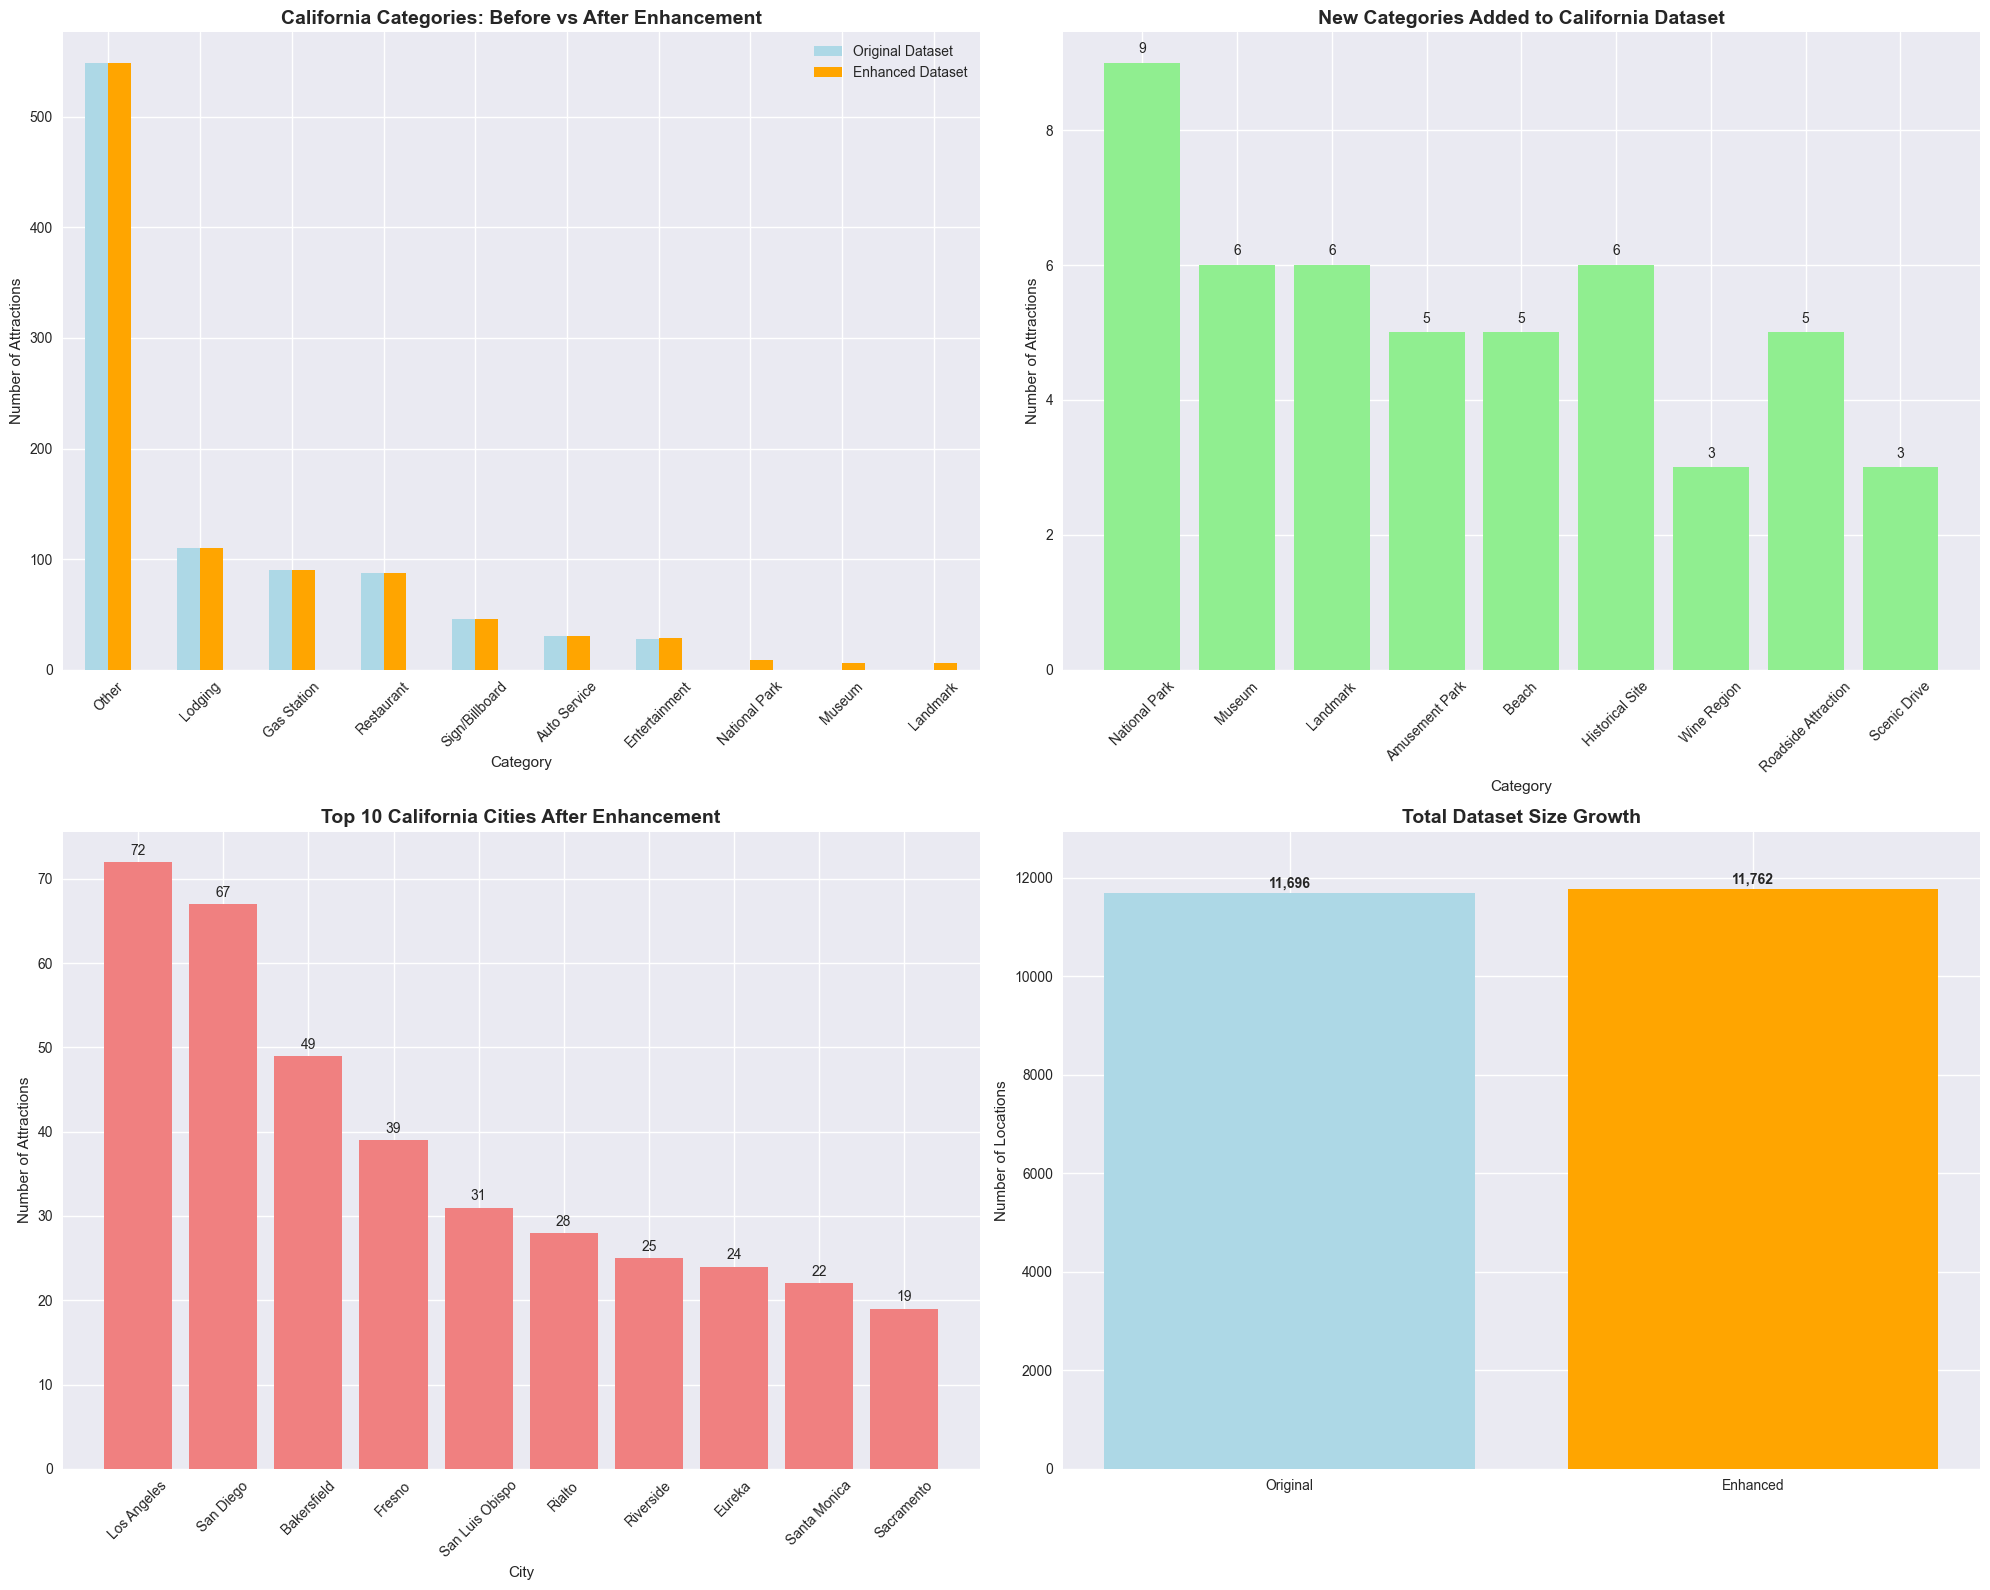

ENHANCEMENT SUMMARY
Original California locations: 944
Enhanced California locations: 1010
Growth: +66 locations (+7.0%)

New categories added: 9
Total categories in enhanced dataset: 27

Major additions:
  • National Parks: 9
  • Amusement Parks: 5
  • Museums: 6
  • Landmarks: 6
  • Beaches: 5
  • Wine Regions: 3

Enhanced dataset saved as: enhanced_attractions.csv


In [8]:
# Create comprehensive visualizations of the enhanced dataset
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Before vs After California categories comparison
original_ca = df[df['state'] == 'CA']
enhanced_ca = combined_df[combined_df['state'] == 'CA']

# Get top categories for comparison
top_categories = ['Other', 'Lodging', 'Gas Station', 'Restaurant', 'Sign/Billboard', 
                 'Auto Service', 'Entertainment', 'National Park', 'Museum', 'Landmark']

original_counts = original_ca['category'].value_counts()
enhanced_counts = enhanced_ca['category'].value_counts()

# Create comparison data
comparison_data = pd.DataFrame({
    'Original': [original_counts.get(cat, 0) for cat in top_categories],
    'Enhanced': [enhanced_counts.get(cat, 0) for cat in top_categories]
}, index=top_categories)

comparison_data.plot(kind='bar', ax=ax1, color=['lightblue', 'orange'])
ax1.set_title('California Categories: Before vs After Enhancement', fontsize=14, fontweight='bold')
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Attractions')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(['Original Dataset', 'Enhanced Dataset'])

# 2. New categories added
new_categories = ['National Park', 'Museum', 'Landmark', 'Amusement Park', 'Beach', 
                 'Historical Site', 'Wine Region', 'Roadside Attraction', 'Scenic Drive']
new_counts = [enhanced_counts.get(cat, 0) for cat in new_categories]

bars = ax2.bar(new_categories, new_counts, color='lightgreen')
ax2.set_title('New Categories Added to California Dataset', fontsize=14, fontweight='bold')
ax2.set_xlabel('Category')
ax2.set_ylabel('Number of Attractions')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, new_counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             str(count), ha='center', va='bottom')

# 3. California cities representation
ca_cities_enhanced = []
for title in enhanced_ca['title']:
    if ',' in title:
        parts = title.split(',')
        if len(parts) >= 2:
            city = parts[-2].strip()
            if city and len(city) < 50:
                ca_cities_enhanced.append(city)

city_counts_enhanced = Counter(ca_cities_enhanced)
top_cities = city_counts_enhanced.most_common(10)
cities, counts = zip(*top_cities)

bars = ax3.bar(cities, counts, color='lightcoral')
ax3.set_title('Top 10 California Cities After Enhancement', fontsize=14, fontweight='bold')
ax3.set_xlabel('City')
ax3.set_ylabel('Number of Attractions')
ax3.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

# 4. Overall dataset growth
dataset_sizes = ['Original', 'Enhanced']
sizes = [len(df), len(combined_df)]
colors = ['lightblue', 'orange']

bars = ax4.bar(dataset_sizes, sizes, color=colors)
ax4.set_title('Total Dataset Size Growth', fontsize=14, fontweight='bold')
ax4.set_ylabel('Number of Locations')
ax4.set_ylim(0, max(sizes) * 1.1)

# Add value labels on bars
for bar, size in zip(bars, sizes):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{size:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("ENHANCEMENT SUMMARY")
print("=" * 60)
print(f"Original California locations: {len(original_ca)}")
print(f"Enhanced California locations: {len(enhanced_ca)}")
print(f"Growth: +{len(enhanced_ca) - len(original_ca)} locations (+{((len(enhanced_ca) - len(original_ca)) / len(original_ca) * 100):.1f}%)")
print(f"\nNew categories added: {len(new_categories)}")
print(f"Total categories in enhanced dataset: {len(enhanced_ca['category'].unique())}")
print(f"\nMajor additions:")
print(f"  • National Parks: {enhanced_counts.get('National Park', 0)}")
print(f"  • Amusement Parks: {enhanced_counts.get('Amusement Park', 0)}")
print(f"  • Museums: {enhanced_counts.get('Museum', 0)}")
print(f"  • Landmarks: {enhanced_counts.get('Landmark', 0)}")
print(f"  • Beaches: {enhanced_counts.get('Beach', 0)}")
print(f"  • Wine Regions: {enhanced_counts.get('Wine Region', 0)}")
print(f"\nEnhanced dataset saved as: enhanced_attractions.csv")
print("=" * 60)